In [1]:
import os

midis = []

for root, directories, filenames in os.walk("midi/"):
    for filename in filenames:
        midis.append(os.path.join(root,filename))

print("There are {} MIDIs.".format(len(midis)))

There are 3878 MIDIs.


In [2]:
composers = []

#first '/' = 5
#second '/' = files[i][5:].find('/')+5

for i in range(len(midis)):
    composers.append(midis[i][5:midis[i][5:].find('/')+5])

In [3]:
composer_list = list(set(composers))
num_songs = []

for i in range(len(composer_list)):
    num_songs.append(composers.count(composer_list[i]))

print("There are {} composers.".format(len(composer_list)))

There are 42 composers.


mozart 1488
haydn 756
beethoven 683
schubert 294
bach 138
kleine 70
soler 65
albeniz 62
clementi 51
danzi 36

The dataset is 38% Mozart


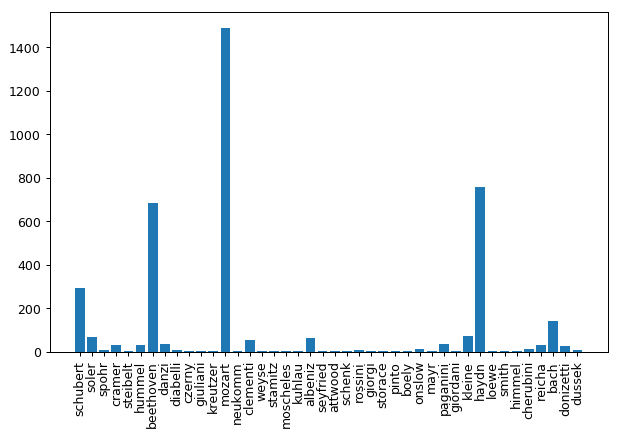

In [7]:
from matplotlib import pyplot as plt
import pandas as pd

top_songs = pd.Series(num_songs).nlargest(10)

for num in top_songs:
    print(composer_list[num_songs.index(num)], num)

print("\nThe dataset is {}% Mozart.".format(round(100*num_songs[composer_list.index('mozart')]/len(midis))))

plt.figure(figsize=(8, 5), dpi=90)
plt.bar(composer_list, num_songs)
plt.xticks(rotation=90)
plt.show()

In [5]:
import os

from magenta.music import midi_io
from magenta.music import note_sequence_io
import tensorflow as tf

def convert_files(root_dir, sub_dir, writer, recursive=False):
  dir_to_convert = os.path.join(root_dir, sub_dir)
  tf.logging.info("Converting files in '%s'.", dir_to_convert)
  files_in_dir = tf.gfile.ListDirectory(os.path.join(dir_to_convert))
  recurse_sub_dirs = []
  written_count = 0
  for file_in_dir in files_in_dir:
    tf.logging.log_every_n(tf.logging.INFO, '%d files converted.',
                           1000, written_count)
    full_file_path = os.path.join(dir_to_convert, file_in_dir)
    if (full_file_path.lower().endswith('.mid') or
        full_file_path.lower().endswith('.midi')):
      try:
        sequence = convert_midi(root_dir, sub_dir, full_file_path)
      except Exception as exc:  # pylint: disable=broad-except
        tf.logging.fatal('%r generated an exception: %s', full_file_path, exc)
        continue
      if sequence:
        writer.write(sequence)
    else:
      if recursive and tf.gfile.IsDirectory(full_file_path):
        recurse_sub_dirs.append(os.path.join(sub_dir, file_in_dir))
      else:
        tf.logging.warning(
            'Unable to find a converter for file %s', full_file_path)

  for recurse_sub_dir in recurse_sub_dirs:
    convert_files(root_dir, recurse_sub_dir, writer, recursive)


def convert_midi(root_dir, sub_dir, full_file_path):
  try:
    sequence = midi_io.midi_to_sequence_proto(
        tf.gfile.FastGFile(full_file_path, 'rb').read())
  except midi_io.MIDIConversionError as e:
    tf.logging.warning(
        'Could not parse MIDI file %s. It will be skipped. Error was: %s',
        full_file_path, e)
    return None
  sequence.collection_name = os.path.basename(root_dir)
  sequence.filename = os.path.join(sub_dir, os.path.basename(full_file_path))
  sequence.id = note_sequence_io.generate_note_sequence_id(
      sequence.filename, sequence.collection_name, 'midi')
  tf.logging.info('Converted MIDI file %s.', full_file_path)
  return sequence

def convert_directory(root_dir, output_file, recursive=False):
  with note_sequence_io.NoteSequenceRecordWriter(output_file) as writer:
    convert_files(root_dir, '', writer, recursive)

def mainconvert():
  input_dir = os.path.expanduser("./midi/")
  output_file = os.path.expanduser("./notesequences.tfrecord")
  output_dir = os.path.dirname(".")

  if output_dir:
    tf.gfile.MakeDirs(output_dir)

  convert_directory(input_dir, output_file, FLAGS.recursive)

ModuleNotFoundError: No module named 'magenta'

In [ ]:
import os

from magenta.models.polyphony_rnn import polyphony_model
from magenta.models.polyphony_rnn import polyphony_rnn_pipeline
from magenta.pipelines import pipeline
import tensorflow as tf

def mainseparate():
    pipeline_instance = polyphony_rnn_pipeline.get_pipeline(
        min_steps=80,  # 5 measures
        max_steps=512,
        eval_ratio=0.1,
        config=polyphony_model.default_configs['polyphony'])
    input_dir = os.path.expanduser("./midi/")
    output_dir = os.path.expanduser(".")
    pipeline.run_pipeline_serial(
      pipeline_instance,
      pipeline.tf_record_iterator(input_dir, pipeline_instance.input_type),
      output_dir)